In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [10]:
import urllib.request

# URL of the helper functions script
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

# Save the downloaded file
urllib.request.urlretrieve(url, "helper_functions.py")


('helper_functions.py', <http.client.HTTPMessage at 0x2261f829e10>)

In [31]:
# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

In [34]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [47]:
# Walk through each directory
dataset = r"C:\Users\Lenovo\Downloads\PW materials\Jupyter_notebook code\pest_classification\dataset"

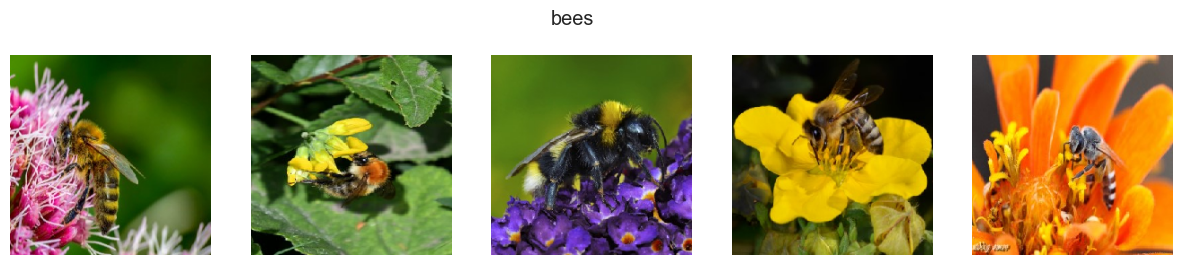

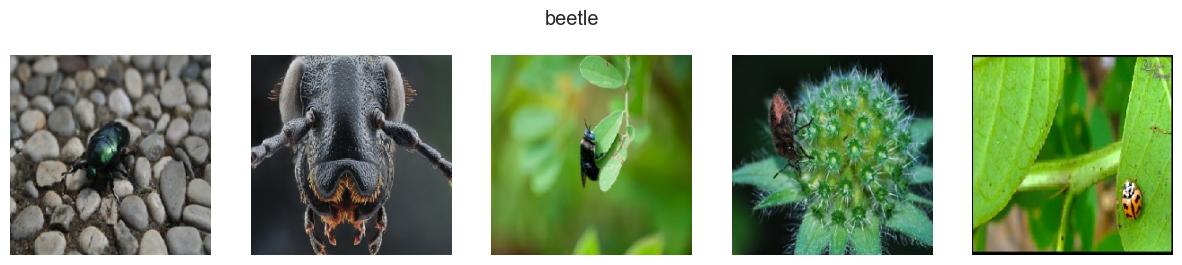

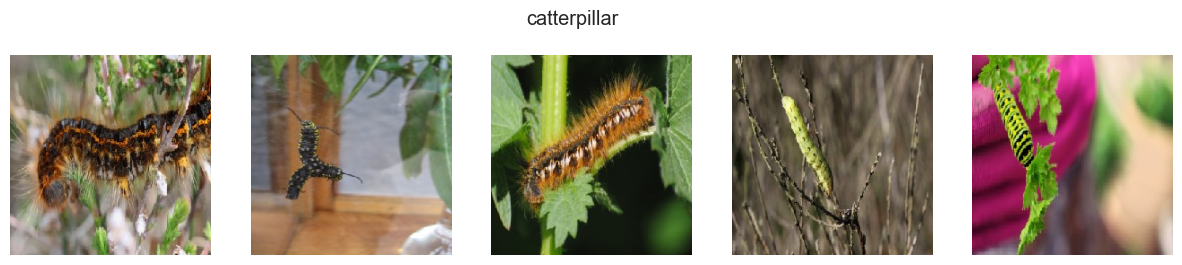

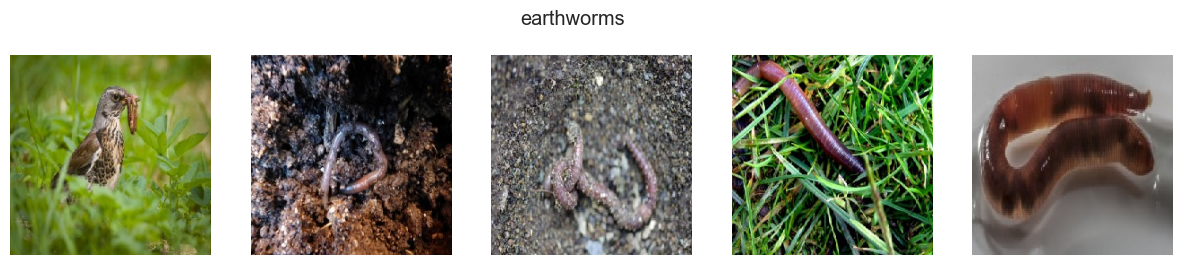

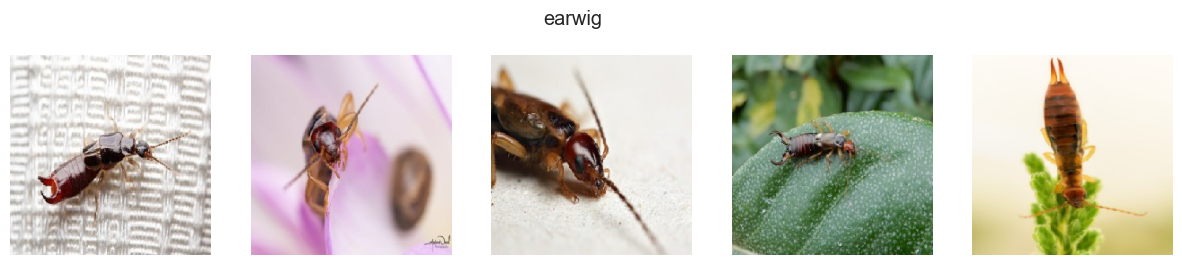

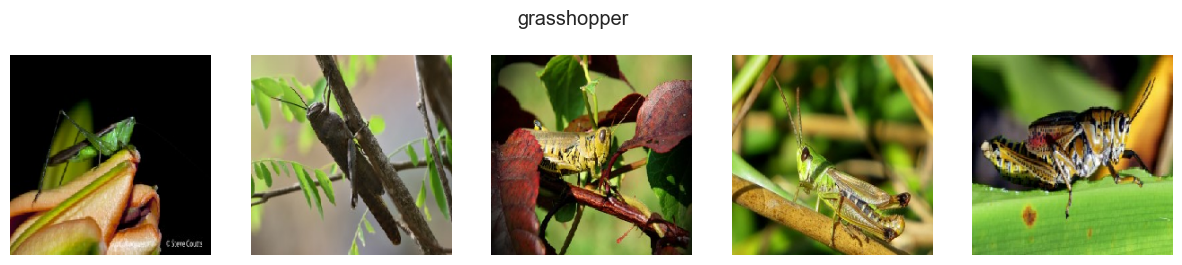

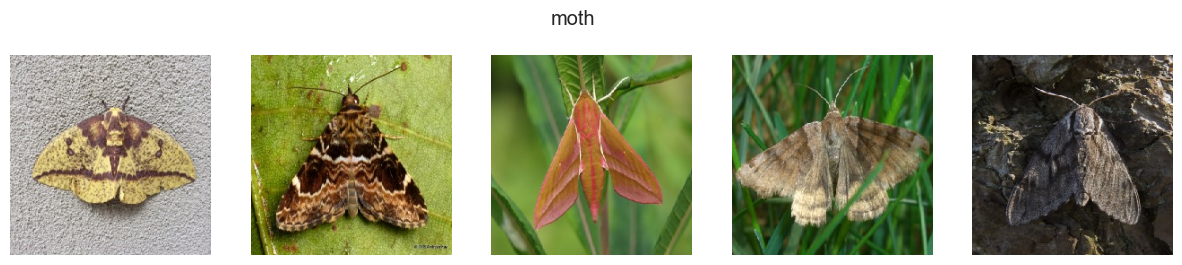

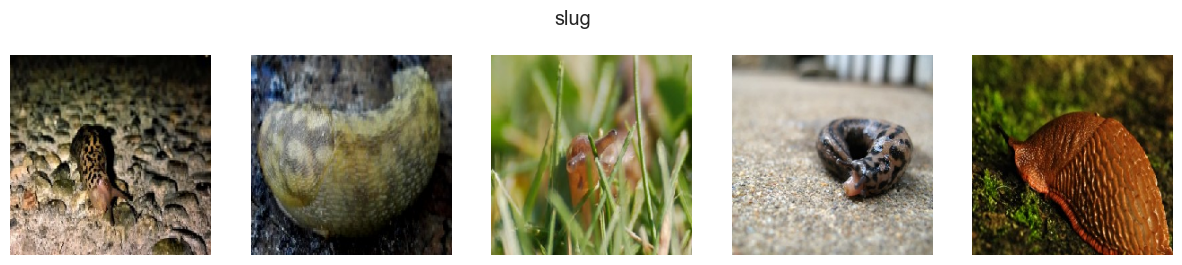

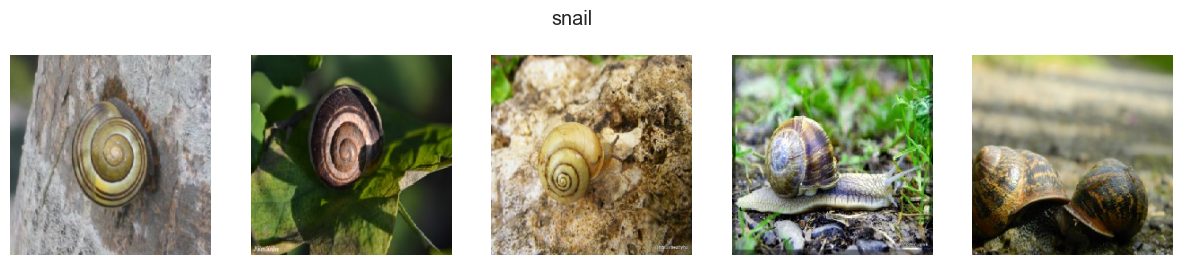

In [49]:
from tensorflow.keras.preprocessing.image import load_img
# Step 2: Print 5 Images from Each Pest Subfolder

# Loop through each pest subfolder
for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    # Check if the current item is a directory (pest subfolder)
    if os.path.isdir(folder_path):
        # Get a list of all images in the current pest subfolder
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly select 5 images from the list
        selected_images = random.sample(images, 5)

        # Print the selected images in multiple columns
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(folder_name)

        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(folder_path, image_name)
            image = load_img(image_path, target_size=(224, 224))

            axes[i].imshow(image)
            axes[i].axis('off')

        plt.show()

In [78]:
# Step 2: Create DataFrame and Store Data

# Initialize lists to store image paths and corresponding labels
image_paths = []
labels = []

# Loop through each pest subfolder
for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    # Check if the current item is a directory (pest subfolder)
    if os.path.isdir(folder_path):
        # Get a list of all images in the current pest subfolder
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)
            image_paths.append(image_path)
            labels.append(folder_name)

# Create a DataFrame from the collected data
data = {
    'image_path': image_paths,
    'label': labels
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

                                             image_path   label
0     C:\Users\Lenovo\Downloads\PW materials\Jupyter...    ants
1     C:\Users\Lenovo\Downloads\PW materials\Jupyter...    ants
2     C:\Users\Lenovo\Downloads\PW materials\Jupyter...    ants
3     C:\Users\Lenovo\Downloads\PW materials\Jupyter...    ants
4     C:\Users\Lenovo\Downloads\PW materials\Jupyter...    ants
...                                                 ...     ...
5489  C:\Users\Lenovo\Downloads\PW materials\Jupyter...  weevil
5490  C:\Users\Lenovo\Downloads\PW materials\Jupyter...  weevil
5491  C:\Users\Lenovo\Downloads\PW materials\Jupyter...  weevil
5492  C:\Users\Lenovo\Downloads\PW materials\Jupyter...  weevil
5493  C:\Users\Lenovo\Downloads\PW materials\Jupyter...  weevil

[5494 rows x 2 columns]


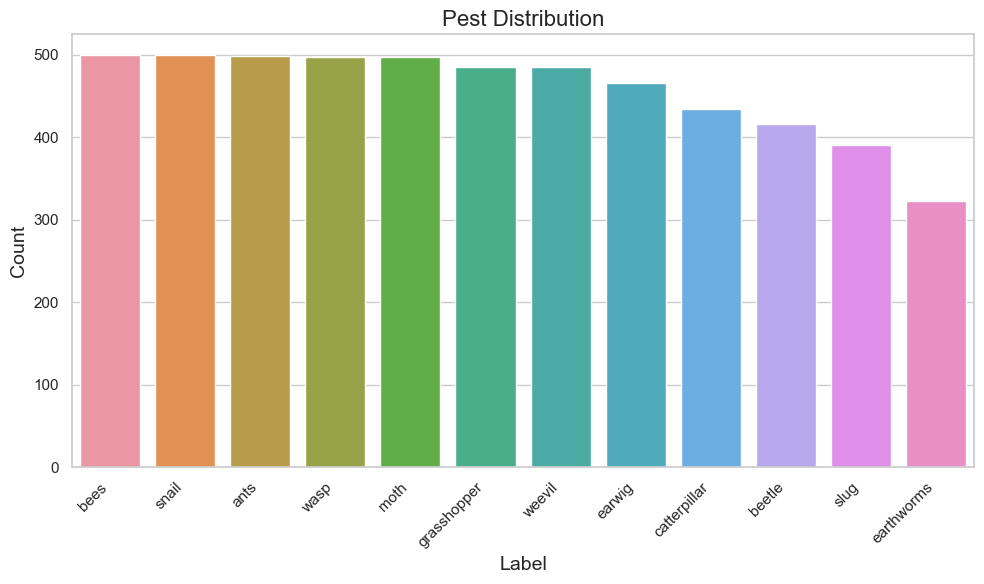

In [51]:
import seaborn as sns
# Plot the label distribution as a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')  # Use a white grid background

# Generate the bar plot
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values)

# Customize the plot
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Pest Distribution', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
# Separate in train and test data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [53]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [54]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3516 validated image filenames belonging to 12 classes.
Found 879 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.


In [55]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.models import Sequential

# Data Augmentation Step
augment = Sequential([
    RandomFlip("horizontal"),            # Random horizontal flipping
    RandomRotation(factor=0.2),          # Random rotation up to 20 degrees
    RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zooming up to 10%
    RandomContrast(factor=0.1),          # Random contrast adjustment up to 10%
])

In [56]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max'
)

resnet_model.trainable = False

# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

94765736/94765736 [==============================] - 59s 1us/step


In [57]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # watch the validation loss metric
                               patience=5,         # stop training if no improvement for 5 epochs
                               restore_best_weights=True)  # restore best weights based on validation loss

# Add additional layers for the custom head of the model
inputs = resnet_model.input
x = augment(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = resnet_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(12, activation='softmax')(x)

In [58]:
# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/100
110/110 [==============================] - 774s 7s/step - loss: 4.5791 - accuracy: 0.1089 - val_loss: 2.4050 - val_accuracy: 0.1661
Epoch 2/100
110/110 [==============================] - 819s 7s/step - loss: 2.4990 - accuracy: 0.1342 - val_loss: 2.3475 - val_accuracy: 0.1832
Epoch 3/100
110/110 [==============================] - 711s 6s/step - loss: 2.4007 - accuracy: 0.1630 - val_loss: 2.2661 - val_accuracy: 0.2673
Epoch 4/100
110/110 [==============================] - 691s 6s/step - loss: 2.3184 - accuracy: 0.2053 - val_loss: 2.1195 - val_accuracy: 0.3891
Epoch 5/100
110/110 [==============================] - 710s 6s/step - loss: 2.1902 - accuracy: 0.2799 - val_loss: 1.9008 - val_accuracy: 0.4824
Epoch 6/100
110/110 [==============================] - 703s 6s/step - loss: 2.0852 - accuracy: 0.3183 - val_loss: 1.7069 - val_accuracy: 0.5392
Epoch 7/100
110/110 [==============================] - 731s 7s/step - loss: 1.9407 - accuracy: 0.3746 - val_loss: 1.5777 - val_accuracy:

In [59]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

35/35 [==============================] - 160s 5s/step - loss: 0.5922 - accuracy: 0.8298
Test Loss: 0.5921570062637329
Test Accuracy: 0.8298453092575073


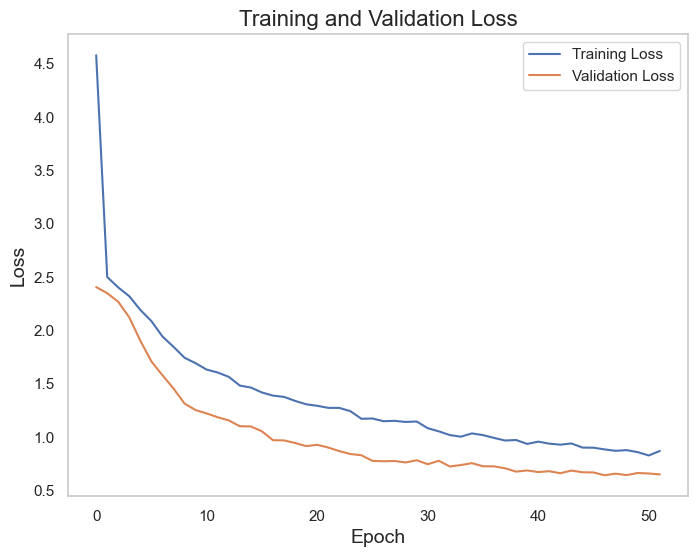

In [61]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [62]:
class_names = ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail',
       'catterpillar', 'weevil', 'bees', 'moth', 'wasp', 'slug']  # Replace with your actual class names

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_images.classes

# Calculate the accuracy of the model on the test data
accuracy = np.mean(predicted_labels == true_labels)
print("Test Accuracy:", accuracy)

# Print some sample predictions along with true labels
num_samples = 10
print("Sample Predictions:")
for i in range(num_samples):
    print("True Label:", class_names[true_labels[i]], "| Predicted Label:", class_names[predicted_labels[i]])

35/35 [==============================] - 159s 4s/step
Test Accuracy: 0.8298453139217471
Sample Predictions:
True Label: earwig | Predicted Label: earwig
True Label: grasshopper | Predicted Label: grasshopper
True Label: earwig | Predicted Label: earwig
True Label: earthworms | Predicted Label: earthworms
True Label: wasp | Predicted Label: wasp
True Label: bees | Predicted Label: bees
True Label: beetle | Predicted Label: beetle
True Label: slug | Predicted Label: slug
True Label: moth | Predicted Label: moth
True Label: earthworms | Predicted Label: beetle


1/1 [==============================] - 2s 2s/step


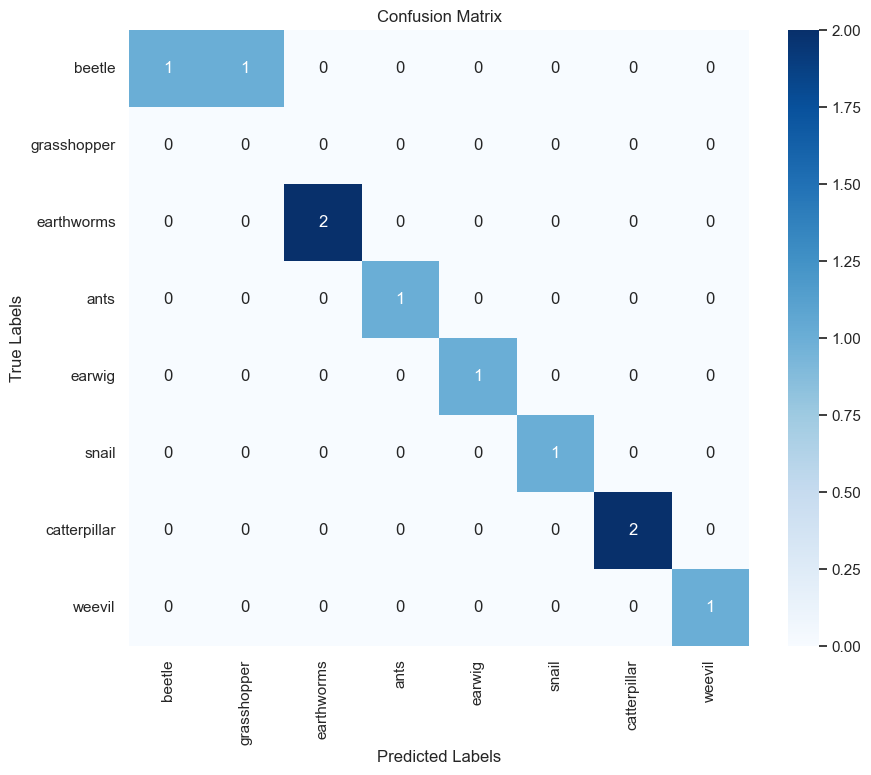

Classification Report:
              precision    recall  f1-score   support

      beetle       1.00      0.50      0.67         2
 grasshopper       0.00      0.00      0.00         0
  earthworms       1.00      1.00      1.00         2
        ants       1.00      1.00      1.00         1
      earwig       1.00      1.00      1.00         1
       snail       1.00      1.00      1.00         1
catterpillar       1.00      1.00      1.00         2
      weevil       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.88      0.81      0.83        10
weighted avg       1.00      0.90      0.93        10



C:\PYHTON 106\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\PYHTON 106\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\PYHTON 106\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail','catterpillar', 'weevil']
# Get a batch of test data (you can adjust the batch size as needed)
batch_size = 10
test_data = next(iter(test_images))
images = test_data[0][:batch_size]  # Get the images from the test data batch
true_labels = test_data[1][:batch_size]  # Get the true labels from the test data batch

# Make predictions on the test data
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert the one-hot encoded true_labels to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [65]:
from tensorflow.keras.applications import InceptionV3

# Load the pretained model
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = True

# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # watch the validation loss metric
                               patience=5,         # stop training if no improvement for 5 epochs
                               restore_best_weights=True)  # restore best weights based on validation loss

# Add additional layers for the custom head of the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = augment(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = pretrained_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(12, activation='softmax')(x)

87910968/87910968 [==============================] - 556s 6us/step


In [66]:
# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/100
110/110 [==============================] - 1337s 12s/step - loss: 2.3219 - accuracy: 0.2733 - val_loss: 1.2263 - val_accuracy: 0.6496
Epoch 2/100
110/110 [==============================] - 1310s 12s/step - loss: 1.3833 - accuracy: 0.5629 - val_loss: 0.7960 - val_accuracy: 0.7656
Epoch 3/100
110/110 [==============================] - 1316s 12s/step - loss: 0.9993 - accuracy: 0.6943 - val_loss: 0.6604 - val_accuracy: 0.8305
Epoch 4/100
110/110 [==============================] - 1197s 11s/step - loss: 0.8486 - accuracy: 0.7602 - val_loss: 0.5500 - val_accuracy: 0.8441
Epoch 5/100
110/110 [==============================] - 1191s 11s/step - loss: 0.6973 - accuracy: 0.8026 - val_loss: 0.6002 - val_accuracy: 0.8453
Epoch 6/100
110/110 [==============================] - 1187s 11s/step - loss: 0.6573 - accuracy: 0.8137 - val_loss: 0.6374 - val_accuracy: 0.8419
Epoch 7/100
110/110 [==============================] - 1192s 11s/step - loss: 0.5624 - accuracy: 0.8424 - val_loss: 0.5755 -

In [67]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

35/35 [==============================] - 76s 2s/step - loss: 0.4687 - accuracy: 0.8653
Test Loss: 0.46867668628692627
Test Accuracy: 0.8653321266174316


In [68]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend()
plt.grid()
plt.show()

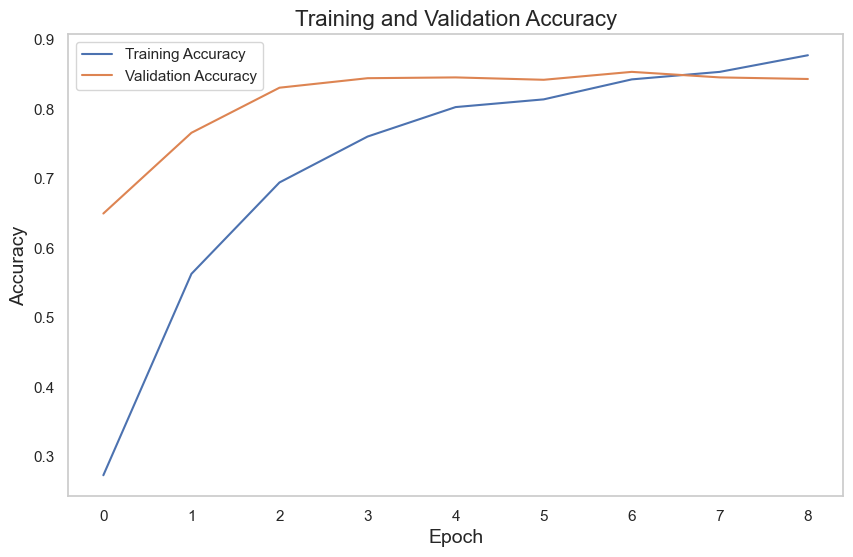

In [69]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [70]:
class_names = ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail',
       'catterpillar', 'weevil', 'bees', 'moth', 'wasp', 'slug']  # Replace with your actual class names

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_images.classes

# Calculate the accuracy of the model on the test data
accuracy = np.mean(predicted_labels == true_labels)
print("Test Accuracy:", accuracy)

# Print some sample predictions along with true labels
num_samples = 10
print("Sample Predictions:")
for i in range(num_samples):
    print("True Label:", class_names[true_labels[i]], "| Predicted Label:", class_names[predicted_labels[i]])

35/35 [==============================] - 79s 2s/step
Test Accuracy: 0.8653321201091901
Sample Predictions:
True Label: earwig | Predicted Label: earwig
True Label: grasshopper | Predicted Label: wasp
True Label: earwig | Predicted Label: earwig
True Label: earthworms | Predicted Label: earthworms
True Label: wasp | Predicted Label: wasp
True Label: bees | Predicted Label: bees
True Label: beetle | Predicted Label: beetle
True Label: slug | Predicted Label: slug
True Label: moth | Predicted Label: moth
True Label: earthworms | Predicted Label: slug
